In [1]:
import itertools

import yaml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import lab.metrics
import lab.analytics

In [2]:
# Load the sizes from the configuration file
with open("../config/config.yaml", mode="r") as configfile:
    CONFIG = yaml.safe_load(configfile)
CONFIG

{'traces': {'monitored': '../removing-control-packets/results/filtered/monitored-traces.hdf',
  'unmonitored': '../removing-control-packets/results/filtered/unmonitored-traces.hdf'},
 'classifiers': ['dfnet', 'varcnn', 'p1fp', 'kfp'],
 'classifier_time': {'dfnet': 70, 'kfp': 10},
 'n_repetitions': 10,
 'quic_deployment_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

In [3]:
def load_classifier_prediction(classifier: str, factor: str, rep: int):
    if classifier == "varcnn":
        return (load_classifier_prediction("varcnn-sizes", factor, rep)
                + load_classifier_prediction("varcnn-time", factor, rep)) / 2
    return pd.read_csv(
        f"../results/predictions-{classifier}-{factor}-{rep:02d}.csv",
        header=0, names=["y_true"] + list(range(-1, 100)))

def load_results():
    combinations = [(classifier, factor, rep)
                    for classifier in ["dfnet", "varcnn", "p1fp", "kfp"]
                    for factor in ["bgquic", "quic", "control"]
                    for rep in range(CONFIG["n_repetitions"])]
        
    return (pd.concat([
        load_classifier_prediction(classifier, factor, rep)
        for (classifier, factor, rep) in combinations
    ], keys=combinations, names=["classifier", "factor", "run", "sample"])
            .drop(columns=[-1]))


data = load_results()
data

y_true             0             1  \
classifier factor  run sample                                       
dfnet      bgquic  0   0         -1.0  8.641420e-22  6.068292e-16   
                       1         -1.0  1.054414e-08  6.983053e-11   
                       2         -1.0  1.839594e-10  5.348780e-18   
                       3         85.0  3.472684e-10  2.264830e-08   
                       4         -1.0  1.951734e-08  2.797050e-10   
...                               ...           ...           ...   
kfp        control 9   5852      -1.0  0.000000e+00  0.000000e+00   
                       5853      -1.0  0.000000e+00  0.000000e+00   
                       5854      -1.0  0.000000e+00  0.000000e+00   
                       5855      -1.0  0.000000e+00  0.000000e+00   
                       5856      -1.0  0.000000e+00  0.000000e+00   

                                          2             3             4  \
classifier factor  run sample                                             
dfnet      bgquic  0   0       7.026364e-14  1.571981e-12  1.309063e-19   
                       1       4.264051e-06  5.993084e-08  1.767725e-11   
                       2       6.076204e-15  5.783835e-16  5.914418e-11   
                       3       5.353236e-18  2.001440e-12  4.407843e-12   
                       4       4.951522e-06  1.036843e-06  1.275554e-09   
...                                     ...           ...           ...   
kfp        control 9   5852    0.000000e+00  0.000000e+00  0.000000e+00   
                       5853    0.000000e+00  0.000000e+00  0.000000e+00   
                       5854    0.000000e+00  0.000000e+00  0.000000e+00   
                       5855    0.000000e+00  0.000000e+00  0.000000e+00   
                       5856    0.000000e+00  0.000000e+00  0.000000e+00   

                                          5             6             7  \
classifier factor  run sample                                             
dfnet      bgquic  0   0       6.689348e-15  2.438565e-17  7.302184e-17   
                       1       4.591279e-07  8.275363e-06  1.872238e-07   
                       2       2.905587e-10  2.634524e-10  2.013264e-13   
                       3       2.492408e-05  5.996313e-14  1.269785e-13   
                       4       9.797326e-07  3.032402e-07  1.344438e-08   
...                                     ...           ...           ...   
kfp        control 9   5852    0.000000e+00  0.000000e+00  0.000000e+00   
                       5853    0.000000e+00  0.000000e+00  0.000000e+00   
                       5854    0.000000e+00  0.000000e+00  0.000000e+00   
                       5855    0.000000e+00  0.000000e+00  0.000000e+00   
                       5856    0.000000e+00  0.000000e+00  0.000000e+00   

                                          8  ...            90            91  \
classifier factor  run sample                ...                               
dfnet      bgquic  0   0       3.346070e-15  ...  6.328703e-25  1.888498e-12   
                       1       1.201466e-07  ...  7.085785e-11  2.003855e-08   
                       2       6.427315e-08  ...  4.268217e-15  3.749670e-12   
                       3       5.587699e-13  ...  5.014401e-17  7.332505e-13   
                       4       8.220174e-07  ...  3.052047e-11  1.892565e-07   
...                                     ...  ...           ...           ...   
kfp        control 9   5852    0.000000e+00  ...  0.000000e+00  0.000000e+00   
                       5853    0.000000e+00  ...  0.000000e+00  0.000000e+00   
                       5854    0.000000e+00  ...  0.000000e+00  0.000000e+00   
                       5855    0.000000e+00  ...  0.000000e+00  0.000000e+00   
                       5856    0.000000e+00  ...  0.000000e+00  0.000000e+00   

                                         92            93            94  \
classifier factor  run sample                                    

In [4]:
def precision_recall_curve(df):
    return pd.DataFrame(lab.analytics.rprecision_recall_curve(
        df["y_true"], df.drop("y_true", axis=1), ratio=20
    )._asdict())

In [12]:
def plot_pr_curve(data):
    data = (data
            .transform(lambda x: x*100)
            .rename({"dfnet": "DF", "varcnn": "Var-CNN", "p1fp": "$p$-FP(C)", "kfp": "$k$-FP"}, axis=0)
            .rename({"precision": "$\pi_{20}$ (\%)", "recall": "Recall (\%)"}, axis=1)
            .rename({"bgquic": "Unmon.", "quic": "Both", "control": "Control"}, axis=0)
            .reset_index())

    with plt.style.context(["./mpl-style/pr-curve.mplstyle", "./mpl-style/pets.mplstyle", {"text.usetex": True}]):
        grid = sns.relplot(
            data=data, x="Recall (\%)", y="$\pi_{20}$ (\%)", hue="factor",
            style="factor", col="classifier", kind="line", height=1.125, aspect=1.33,
            facet_kws=dict(legend_out=True, despine=False,
                           gridspec_kws=dict(wspace=.1)),
            palette="binary", legend=False
        )
        grid.set_titles(col_template="{col_name}")
        
        for i, ax in enumerate(np.ravel(grid.axes)):
            if i == 0:
                ax.legend(labels=["Unmon.", "Control", "Both"])
            ax.set_xticks([0, 50, 100])
            ax.set_yticks([0, 50, 100])
            ax.xaxis.get_major_formatter()._usetex = False
            ax.yaxis.get_major_formatter()._usetex = False
        
    return grid

/home/jsmith/Projects/quic-traffic-analysis/env/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/home/jsmith/Projects/quic-traffic-analysis/env/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


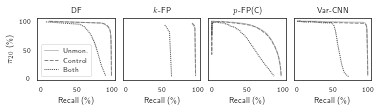

In [13]:
figure = (data.groupby(["classifier", "factor"])
          .apply(precision_recall_curve)
          .set_index("thresholds", append=True)
          .pipe(plot_pr_curve))

figure.savefig("../results/plots/quic-presence-prcurve.png", dpi=150, bbox_inches="tight")
figure.savefig("../results/plots/quic-presence-prcurve.pgf", dpi=150, bbox_inches="tight")

In [14]:
def make_binary_predictions(data):
    data = data.copy()
    data["score"] = data[np.arange(0, 100)].sum(axis=1)
    data["y_true"] = data["y_true"].where(data["y_true"] == -1, 0).astype(int)
    return data[["y_true", "score"]]

binary_data = (make_binary_predictions(data)
               .groupby(["classifier", "factor"])
               .apply(precision_recall_curve)
               .set_index("thresholds", append=True))
binary_data

precision  recall
classifier factor     thresholds                   
dfnet      bgquic 0   0.000        0.047619  1.0000
                  1   0.001        0.256805  0.9970
                  2   0.002        0.286336  0.9964
                  3   0.003        0.305509  0.9961
                  4   0.004        0.319890  0.9959
...                                     ...     ...
varcnn     quic   992 0.996        0.993772  0.0657
                  993 0.997        0.993081  0.0591
                  994 0.998        0.992068  0.0515
                  995 0.999        1.000000  0.0408
                  996 1.000        1.000000  0.0000

[8697 rows x 2 columns]

/home/jsmith/Projects/quic-traffic-analysis/env/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/home/jsmith/Projects/quic-traffic-analysis/env/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


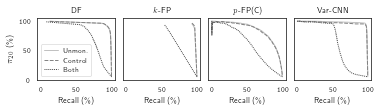

In [15]:
figure = plot_pr_curve(binary_data)

figure.savefig("../results/plots/quic-presence-prcurve-binary.png", dpi=150, bbox_inches="tight")
figure.savefig("../results/plots/quic-presence-prcurve-binary.pgf", dpi=150, bbox_inches="tight")